In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [3]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

#sns.set_style('white')
plt.style.use('dark_background')

In [4]:
def compute_usage(df):
    onsets = np.where(np.diff(df['syllables']) != 0)[0]
    usage = df.loc[df.index[onsets], 'syllables'].value_counts(normalize=True)
    return usage

In [5]:
# filter by syllable usage
def syll_index_above_threshold(mean_df, threshold = 0.01):
    syll_mean_usage = mean_df.groupby(['syllables']).mean()
    return syll_mean_usage[syll_mean_usage > threshold].index.to_list()

In [6]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='magma', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred,name):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    #fig.savefig(data_loc +name+'.pdf', bbox_inches='tight')

In [7]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_females.parquet')
df = pd.read_parquet(path)

In [8]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [9]:
# calculate usage
fusages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
fusage_mtx = pd.pivot_table(fusages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
fusage_mtx.columns = fusage_mtx.columns.droplevel(0)

#filter most used syllables just females
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [10]:
fdf_all = fusage_mtx.copy()

In [11]:
#get random 16 mice per age
n=16
fdf_all = fdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [12]:
## upload data frame males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_02/ontogeny_males.parquet')
df = pd.read_parquet(path)

In [13]:
# change age to weeks
df['age'].replace(['7wks', '3months', '9wks', '12months', '6months', '18months','3wks', '5wks','9months','22months'],
           ['07wks','12wks','09wks','52wks','24wks','78wks','03wks','05wks','36wks','90wks'], inplace=True)

In [14]:
# calculate usage
musages = df.groupby(['age', 'uuid','experiment'], observed=True, sort=False).apply(compute_usage)
musage_mtx = pd.pivot_table(musages.reset_index(), index=['age', 'uuid','experiment'], columns='syllables').fillna(0)
musage_mtx.columns = musage_mtx.columns.droplevel(0)

#filter most used syllables just males
#include_syll = syll_index_above_threshold(usages)
#usage_mtx = usage_mtx[include_syll]

In [15]:
mdf_all = musage_mtx.copy()

In [16]:
#get random 16 mice per age
n=16
mdf_all = mdf_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False)).reset_index(level=0, drop=True)

In [17]:
# filter by use of both sexes
combined_df = pd.concat([musages,fusages]).fillna(0)
include_syll = syll_index_above_threshold(combined_df)
mdf = mdf_all[include_syll]
fdf = fdf_all[include_syll]

In [18]:
# drop sullables that do not exsist in specific sex
combined = pd.concat([fdf_all,mdf_all])
combined.dropna(axis=1,inplace=True) # drop syllables that do not exist in one sex
combined = combined.drop('90wks')
combined = np.log(combined + 1e-6) # convert to linear
combined = combined[include_syll] # still include only above 1% syllables

## fit linear regression for each syllable

In [19]:
combined = combined.groupby(['experiment','age']).mean()

In [20]:
combined.loc[['ontogeny_females']]

syllables                     0         3         6         7         10  \
experiment       age                                                       
ontogeny_females 03wks -3.214508 -4.380054 -6.299748 -3.060993 -3.665486   
                 05wks -3.460330 -3.944406 -5.959326 -3.280056 -3.721741   
                 07wks -3.672361 -3.850587 -5.395989 -3.617841 -3.560911   
                 09wks -3.551463 -3.836404 -5.475863 -3.456383 -3.497536   
                 12wks -3.874558 -3.975273 -4.728741 -3.886771 -3.590738   
                 24wks -4.227503 -3.753792 -5.380271 -4.040308 -3.633718   
                 52wks -4.045847 -4.055628 -4.628311 -4.055557 -3.404162   
                 78wks -4.045980 -3.980213 -4.495774 -4.385674 -3.571385   

syllables                     12        13        14        15        16  ...  \
experiment       age                                                      ...   
ontogeny_females 03wks -3.831675 -5.318261 -4.374064 -9.066985 -4.879983  ...   
                 05wks -3.981711 -4.552092 -4.270839 -7.151877 -5.265667  ...   
                 07wks -4.460868 -4.210127 -4.022098 -5.944575 -5.464128  ...   
                 09wks -4.493676 -4.092216 -4.293328 -5.677743 -5.535041  ...   
                 12wks -4.793954 -3.612254 -4.117211 -5.288795 -6.278700  ...   
                 24wks -5.198968 -3.522997 -4.322801 -4.637470 -5.063904  ...   
                 52wks -5.290056 -3.385818 -4.537827 -4.349131 -4.689921  ...   
                 78wks -5.246825 -3.911790 -4.636178 -4.254799 -4.429602  ...   

syllables                     83        86        88        89        90  \
experiment       age                                                       
ontogeny_females 03wks -4.596658 -2.959997 -2.884589 -3.839980 -4.259332   
                 05wks -4.036569 -2.929845 -3.983293 -3.614316 -4.229640   
                 07wks -3.980244 -2.937703 -4.721242 -4.451622 -4.165226   
                 09wks -4.011163 -2.953492 -5.026287 -4.435646 -4.179135   
                 12wks -3.984501 -2.958829 -5.816267 -5.017873 -4.115832   
                 24wks -3.635256 -3.088069 -5.492237 -6.325776 -4.074041   
                 52wks -4.325162 -3.121486 -5.320479 -5.663961 -4.521216   
                 78wks -4.262959 -3.378927 -5.032433 -9.077887 -4.012014   

syllables                     92        94        96        98        99  
experiment       age                                                      
ontogeny_females 03wks -4.846229 -6.620400 -3.256748 -6.091630 -5.496218  
                 05wks -5.147513 -6.175339 -3.296427 -5.051761 -5.673824  
                 07wks -5.161931 -5.732013 -3.387330 -4.609025 -5.851254  
                 09wks -4.954816 -5.833850 -3.278456 -4.453174 -5.380719  
                 12wks -5.490154 -5.293532 -3.583621 -3.577155 -5.472136  
                 24wks -5.641230 -4.976915 -3.675905 -3.645910 -5.529762  
                 52wks -4.862513 -4.428977 -3.554000 -3.833650 -4.425264  
                 78wks -4.862761 -4.256201 -3.706361 -4.936996 -4.295376  

[8 rows x 49 columns]

In [21]:
# prepare data
mdf_temp = combined.loc[['ontogeny_males']].to_numpy()
fdf_temp = combined.loc[['ontogeny_females']].to_numpy()
x = combined.index.get_level_values(1).unique().to_numpy()

In [23]:
mdf_temp

array([[-3.32184493, -4.00051349, -6.70768156, -3.11729029, -4.04099581,
        -3.72928117, -4.7741068 , -4.43451267, -6.29713773, -4.84085661,
        -3.94845377, -6.02436526, -4.88378346, -5.55400335, -4.62632889,
        -5.10328729, -3.15797186, -3.37257241, -4.27006702, -3.66321574,
        -3.6571527 , -4.43666621, -3.69798968, -4.44363536, -4.32106574,
        -4.34590805, -4.41875599, -3.52458189, -3.42393675, -4.42335052,
        -3.73809972, -7.04399051, -5.44220893, -4.08383736, -2.91967471,
        -4.11762765, -5.2587195 , -5.55064866, -5.11040876, -4.25778073,
        -2.97976843, -3.1062605 , -3.76047305, -4.39624475, -5.32520259,
        -5.89028436, -3.09706946, -5.54090859, -5.44037624],
       [-3.81777143, -3.83372618, -5.17774583, -3.51813256, -4.120253  ,
        -4.62447735, -4.26288595, -4.3210043 , -5.41843315, -4.86247254,
        -3.9077836 , -5.36928787, -4.72726923, -5.55022967, -4.07458386,
        -4.57389912, -3.68353382, -3.21552222, -4.43139074, -3.

In [78]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
x = np.array(range(len(x)))
x = sm.add_constant(x)

fr2=[]
fpvalue=[]
fslop=[]
fexp=[]
mr2=[]
mpvalue=[]
mslop=[]
mexp=[]

for i in range(np.shape(mdf_temp)[1]):
    y=mdf_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    mr2.append(model.rsquared)
    mpvalue.append(model.f_pvalue)
    mslop.append(model.params[1])
    #fexp.append('male')
    
for i in range(np.shape(fdf_temp)[1]):
    y=fdf_temp[:,i]
    #fit linear regression model
    model = sm.OLS(y, x).fit()
    #view model summary
    fr2.append(model.rsquared)
    fpvalue.append(model.f_pvalue)
    fslop.append(model.params[1])
    #fexp.append('female')

In [77]:
len(mslop)

0

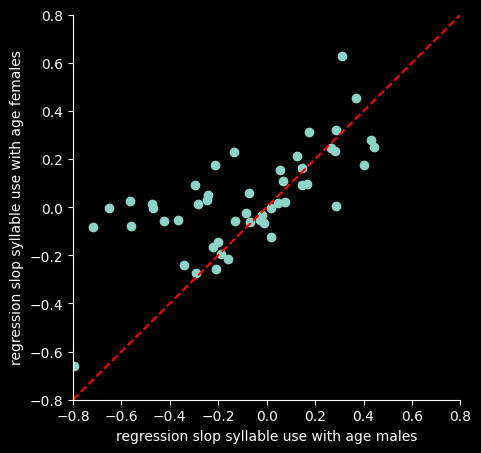

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.scatter(x=mslop, y=fslop)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', c='r')
plt.ylim(-0.8, 0.8)
plt.xlim(-0.8, 0.8)
sns.despine
plt.xlabel('regression slop syllable use with age males')
plt.ylabel('regression slop syllable use with age females')
#plt.title('linear change in syllables in different sexes')
sns.despine()
fig.savefig(data_loc +'corr_male_female_syll.pdf', bbox_inches='tight')

In [ ]:
x = np.array(range(len(x)))
x = x.reshape(-1,1)
y=mdf_temp[:,0]

In [ ]:
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
r2 = regression_model.score(x,y)
  
# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('R2 score: ', r2)

#display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, model.score(X, y))


In [ ]:
#display regression coefficients and R-squared value of model
print(model.intercept_, model.coef_, model.score(X, y))

70.4828205704 [ 5.7945 -1.1576] 0.766742556527

In [ ]:
import statsmodels.api as sm

#define response variable
y = df['y']

#define predictor variables
x = df[['x1', 'x2']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

model.pvalues